# Demonstration of Spectral Processing With `NMRlab`
2025-02-08 Marcel Utz, KIT

## Synopsis
`NMRlab` is a Julia package for handling NMR data. It provides a basic
data structure that is designed to hold NMR data of any type and format.
It holds an ``n``-dimensional array of amplitude values along
with a list of axes. The axes have to be vectors of the same
length as the corresponding dimension of the data array. This structure is capable of handling axes with numerical meaning (time,
frequency, ...), but also lists (sample ID, compound name, experiment
ID, etc). 

`NMRlab` provides processing tools that act on this type of data structure. They can make use of the axis information. For example, a Fourier transform will convert the axis of the time domain data into
a corresponding frequency axis based on the Nyqvist theorem. This notebook provides an illustration of the usage of `NMRlab` to process
1D NMR data.

## Loading `NMRlab`
To load `NMRlab`, we activate a Julia environment that contains the module as a dependency, and then import the module as usual in Julia. We also import ancillary modules that we will need, such as `Plots.jl`.

In [10]:
import Pkg; Pkg.activate("./")
using NMRlab
import Plots

  Activating project at `~/Source/NMRlab`


## Loading NMR data
`NMRlab` comes with a range of example data sets to support testing, 
demonstrations, and training. They can be accessed through the submodule `NMRlab.Examples`. The interface provides the names and paths of files that can be loaded as follows:

In [40]:
ex=NMRlab.Examples.Data["HCC cell culture media spectra"]["files"][1]
params,d=NMRlab.load(ex,:Bruker) ;
d

32693-element SpectData{ComplexF64, 1} with coords:(0.0:7.199999999999995e-5:2.353823999999998,):
  -6.9423121078125e7 + 1.047522298828125e8im
 3.713936376171875e8 - 5.873334321640625e8im
  4.89205430609375e8 - 1.33556210878125e9im
  1.36027642265625e7 - 1.0152351535234375e9im
 -5.90617235546875e7 - 8.273014788203125e8im
  -8.6232552546875e7 - 5.643557254375e8im
     -398472.4296875 - 5.26599649140625e8im
 -1.78959229921875e7 - 4.263141174296875e8im
  1.67038894921875e7 - 3.65753820171875e8im
  4.84514783984375e7 - 2.174211429765625e8im
                     ⋮
      -283007.765625 - 183694.90625im
         -420138.875 + 79240.765625im
         -175130.375 + 254453.578125im
       -25309.578125 + 487678.984375im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im

The `load` command reads a Bruker data directory, and automatically
obtains the acquisition parameters, which are returned as a Julia
dictionary. Moreover, the parameters are used to infer
the horizontal (time) axis, as well as other aspects of the acquisition that are needed for correct loading of the raw data (e.g., floating point or integer data format, endianness, as well as time origin shift as a result of the digital filter´s group delay).

The object `d` can now be used almost like any other 1D array. For example, we can use `Plots.plot()` to visualise the data. `coords(d,1)`
gives access to the time axis:

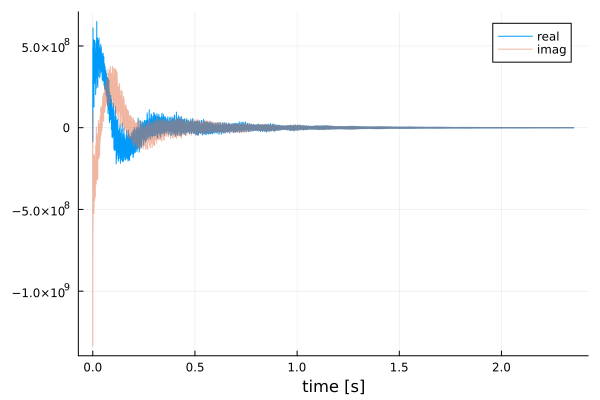

In [31]:
Plots.plot(coords(d,1), real(d),xlabel="time [s]",label="real") 
Plots.plot!(coords(d,1), imag(d),xlabel="time [s]",opacity=0.5,label="imag") 

## Processing NMR data
To process the data, we set up a processing chain, consisting of the
indivdual processing steps. In this case, we zero-fill the data to
64k (``2^{16}``) points, apodize it with a rate of ``0.5\pi\,\mathrm{s^{-1}}``, and then Fourier transform.

In [21]:
process = Chain(
    ZeroFill([2^16]),
    Apodize([0.5π]),
    FourierTransform([2^16],[1])
)

FourierTransform(Integer[1], Integer[65536], true, FFTW forward plan for 65536-element array of ComplexF64
(dft-ct-dit/32
  (dftw-direct-32/8 "t3fv_32_avx2_128")
  (dft-vrank>=1-x32/1
    (dft-ct-dit/32
      (dftw-direct-32/8 "t3fv_32_avx2_128")
      (dft-direct-64-x32 "n2fv_64_avx2_128"))))) ∘ Apodize(Union{Colon, Real}[1.5707963267948966]) ∘ ZeroFill(Union{Colon, Integer}[65536])

In [34]:
s = d |> process
s = s / sqrt(sum(conj(s).*s))

65536-element SpectData{ComplexF64, 1} with coords:(-13888.8888888889:0.4238617193526787:13888.8888888889,):
  4.780984547919303e-5 - 8.803104717712272e-5im
  4.785926254286884e-5 - 8.811130075330622e-5im
  4.787506708975983e-5 - 8.800112792092502e-5im
  4.809137669069913e-5 - 8.783962270132536e-5im
  4.838535272982371e-5 - 8.792839467800588e-5im
 4.8706348696552885e-5 - 8.788189067182656e-5im
   4.95443363886527e-5 - 8.848542282260618e-5im
  4.920044238546322e-5 - 8.984051714114831e-5im
  4.818758663543498e-5 - 8.997489460382101e-5im
  4.802644972702657e-5 - 8.971815386515729e-5im
                       ⋮
 4.9956828818308555e-5 - 8.776740179437344e-5im
  4.958087557890861e-5 - 8.778071298491552e-5im
  5.003710395224684e-5 - 8.779971271702792e-5im
 5.0098975305058375e-5 - 8.887747569217435e-5im
  4.916406367767305e-5 - 8.927791595790306e-5im
  4.889286915554042e-5 - 8.922285761973396e-5im
 4.8283360246067506e-5 - 8.966947425713485e-5im
  4.723074698928887e-5 - 8.915897607038655e-5im
  

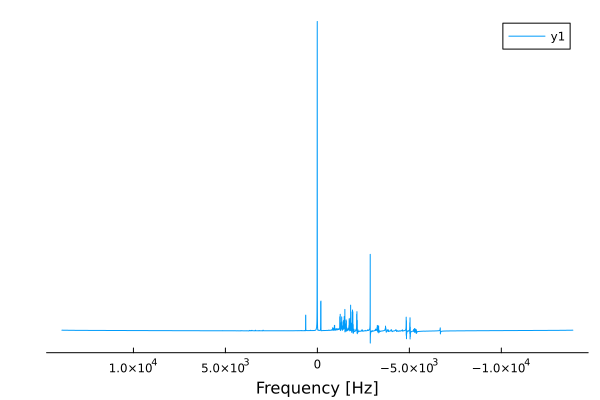

In [39]:
Plots.plot(coords(s,1), real(exp(0.31π*im).*s),xaxis=:flip,xlabel="Frequency [Hz]",yaxis=false,grid=false)